In [11]:
# data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['font.size'] = 15

# machine learning models
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

# statistical test
from scipy.stats import ranksums


## Import Data

In [12]:
avi = pd.read_csv('SnowWeatherCleanFE.csv')
avi.head()

,Unnamed: 0,avi_danger,avg_wind,temp_max_swing,temp_max_swing_from_avg,year,month,day,temp_max,temp_min,...,prevailing_wind_N_2,prevailing_wind_NE_2,prevailing_wind_NW_2,prevailing_wind_S_2,prevailing_wind_SE_2,prevailing_wind_SW_2,prevailing_wind_W_2,three_day_snow_2,five_day_snow_2,next_day_avi_danger
0,0,1.0,20.58,0.0,0.0,2010.0,12.0,20.0,15,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.2,0.2,3.0
1,1,3.0,35.12,3.0,0.0,2010.0,12.0,21.0,18,10,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.3,0.3,2.0
2,2,2.0,33.78,-3.0,0.0,2010.0,12.0,22.0,15,7,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,2.5,3.0
3,3,3.0,31.32,0.0,0.0,2010.0,12.0,23.0,15,6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.3,4.5,2.0
4,4,2.0,32.44,2.0,1.4,2010.0,12.0,24.0,17,9,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.3,8.6,2.0


In [13]:
avi = avi[avi['avi_danger'].notnull()]
x = avi.iloc[:, 0:avi.shape[1]-2]
y = avi.iloc[:, avi.shape[1]-1]

(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)



[[  1. 353.]
 [  2. 469.]
 [  3. 332.]
 [  4.  70.]]


### PCA graph of the danger levels

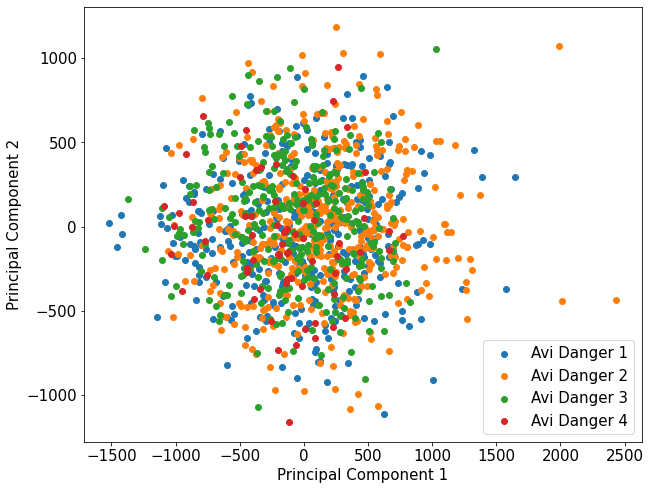

In [14]:

clf = PCA(n_components=2)
transformed_data = clf.fit_transform(x)

#create a scatter plot with different colors for different clases of data-points
class_0 = np.where(y == 1)
class_1 = np.where(y == 2)
class_2 = np.where(y == 3)
class_3 = np.where(y == 4)

# plotting of transformed data by class
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(transformed_data[:, 0][class_0], transformed_data[:, 1][class_0], label = "Avi Danger 1")
plt.scatter(transformed_data[:, 0][class_1], transformed_data[:, 1][class_1], label = "Avi Danger 2")
plt.scatter(transformed_data[:, 0][class_2], transformed_data[:, 1][class_2], label = "Avi Danger 3")
plt.scatter(transformed_data[:, 0][class_3], transformed_data[:, 1][class_3], label = "Avi Danger 4")
plt.legend()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### Make the class weight dictionary

In [16]:
class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

weight_dict = {}
for class_num in range(0, len(class_weight)):
    weight_dict[class_num + 1] = class_weight[class_num]
print(weight_dict)

{1: 0.8668555240793201, 2: 0.652452025586354, 3: 0.9216867469879518, 4: 4.371428571428571}


In [24]:
# prepare models
models = []
models.append(('Logistic Reg', LogisticRegression(tol = 0.0001, solver = 'lbfgs', penalty = 'l2', C = 0.1, max_iter = 10000, class_weight = weight_dict)))
models.append(('Decision Tree', DecisionTreeClassifier(min_samples_split = 5, min_samples_leaf = 1, max_depth = 10, class_weight = weight_dict)))
models.append(('Random Forest', RandomForestClassifier(n_estimators = 800, min_samples_split = 10, min_samples_leaf = 4, 
                                                       max_features = 'sqrt', max_depth = None, bootstrap = False, class_weight = weight_dict)))
models.append(('SVM', SVC(kernel = 'rbf', gamma = 0.01, C = 10, class_weight = weight_dict)))
models.append(('Gradient Boosting', GradientBoostingClassifier(n_estimators=500, max_depth=4, learning_rate=0.05)))
models.append(('K Nearest Neighbors', KNeighborsClassifier(p = 1, n_neighbors = 25, leaf_size = 21)))
models.append(('Extra Trees', ExtraTreesClassifier(n_estimators = 1000, min_samples_split = 10, min_samples_leaf = 1, max_features = 'auto', 
                                                   max_depth = None, bootstrap = True, class_weight = weight_dict)))


In [25]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = model_selection.cross_val_score(model, x, y, cv=10, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = ("Accuracy %s: %0.2f (+/- %0.2f)" % (name, cv_results.mean(), cv_results.std() * 2))
    print(msg)

/Users/lowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Accuracy Logistic Reg: 0.52 (+/- 0.16)
Accuracy Decision Tree: 0.47 (+/- 0.13)
Accuracy Random Forest: 0.58 (+/- 0.14)
Accuracy SVM: 0.38 (+/- 0.01)
Accuracy Gradient Boosting: 0.54 (+/- 0.21)
Accuracy K Nearest Neighbors: 0.39 (+/- 0.12)
Accuracy Extra Trees: 0.62 (+/- 0.09)


Text(0, 0.5, 'Accuracy')

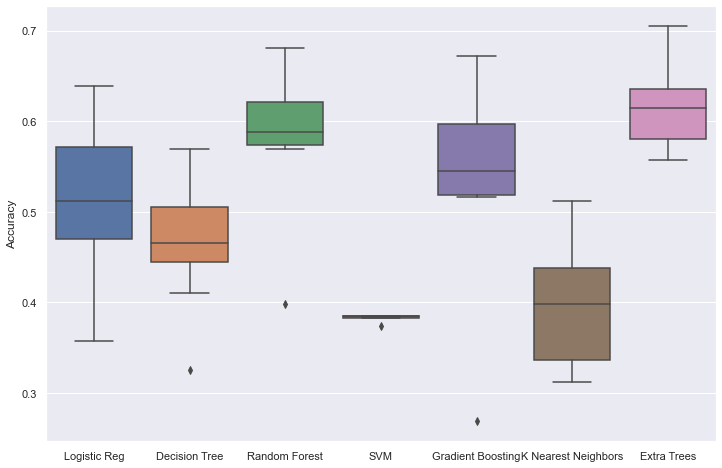

In [26]:
sns.set(font_scale=1)
boxplot = sns.boxplot(data=results)
boxplot.set_xticklabels(names)
plt.ylabel("Accuracy")

In [8]:
uncorrected_pvals = []
comparison_names = []
for i in range(len(results)):
    for j in range(i+1,len(results)):
        print("%20s: %f, %20s: %f, \tp = %f" % (names[i], np.mean(results[i]), 
                                          names[j], np.mean(results[j]),
                                          ranksums(results[i],results[j])[1]))
        uncorrected_pvals.append(ranksums(results[i],results[j])[1])
        comparison_names.append((names[i],names[j]))

        Logistic Reg: 0.603609,        Decision Tree: 0.696188, 	p = 0.005159
        Logistic Reg: 0.603609,        Random Forest: 0.794467, 	p = 0.000157
        Logistic Reg: 0.603609,                  SVM: 0.727391, 	p = 0.002827
        Logistic Reg: 0.603609,    Gradient Boosting: 0.753718, 	p = 0.000183
        Logistic Reg: 0.603609,  K Nearest Neighbors: 0.646475, 	p = 0.677585
        Logistic Reg: 0.603609,          Extra Trees: 0.804999, 	p = 0.000157
       Decision Tree: 0.696188,        Random Forest: 0.794467, 	p = 0.010165
       Decision Tree: 0.696188,                  SVM: 0.727391, 	p = 0.850107
       Decision Tree: 0.696188,    Gradient Boosting: 0.753718, 	p = 0.058782
       Decision Tree: 0.696188,  K Nearest Neighbors: 0.646475, 	p = 0.088973
       Decision Tree: 0.696188,          Extra Trees: 0.804999, 	p = 0.008151
       Random Forest: 0.794467,                  SVM: 0.727391, 	p = 0.082099
       Random Forest: 0.794467,    Gradient Boosting: 0.753718, 

In [9]:
from statsmodels.stats.multitest import multipletests

(significant, corected_pval, _, _) = multipletests(uncorrected_pvals, method='fdr_bh')

for i in range(len(comparison_names)):
    print("%40s: %f \t%s" % (comparison_names[i],corected_pval[i],significant[i]))

       ('Logistic Reg', 'Decision Tree'): 0.021396 	True
       ('Logistic Reg', 'Random Forest'): 0.001279 	True
                 ('Logistic Reg', 'SVM'): 0.014843 	True
   ('Logistic Reg', 'Gradient Boosting'): 0.001279 	True
 ('Logistic Reg', 'K Nearest Neighbors'): 0.711464 	False
         ('Logistic Reg', 'Extra Trees'): 0.001279 	True
      ('Decision Tree', 'Random Forest'): 0.023719 	True
                ('Decision Tree', 'SVM'): 0.850107 	False
  ('Decision Tree', 'Gradient Boosting'): 0.112220 	False
('Decision Tree', 'K Nearest Neighbors'): 0.116777 	False
        ('Decision Tree', 'Extra Trees'): 0.021396 	True
                ('Random Forest', 'SVM'): 0.116777 	False
  ('Random Forest', 'Gradient Boosting'): 0.318542 	False
('Random Forest', 'K Nearest Neighbors'): 0.021396 	True
        ('Random Forest', 'Extra Trees'): 0.659512 	False
            ('SVM', 'Gradient Boosting'): 0.214468 	False
          ('SVM', 'K Nearest Neighbors'): 0.116777 	False
                  ('SV